In [167]:
import pandas as pd
import seaborn as sns
import pandasql as psql
import numpy as np
# from scipy import stats
from scipy.stats import chisquare

In [168]:
sleeps = pd.read_csv("sleep.csv")

average_sleeps = psql.sqldf(
    '''
    SELECT
        egoid,
        dataDate,
        SUM(bedtimedur) as bedtimedur,
        SUM(minstofallasleep) as minstofallasleep,
        SUM(minsafterwakeup) as minsafterwakeup,
        SUM(minsasleep) as minsasleep,
        SUM(minsawake) as minsawake,
        SUM(efficiency * minsasleep) / SUM(minsasleep) as weighted_efficiency
    FROM sleeps
    GROUP BY egoid, dataDate
    '''
)
average_sleeps.to_csv('sleep_data/average_sleeps_1.csv', index=False)

weighted_average_sleeps = psql.sqldf(
    '''
    SELECT
        egoid,
        AVG(bedtimedur) as bedtimedur,
        AVG(minstofallasleep) as minstofallasleep,
        AVG(minsafterwakeup) as minsafterwakeup,
        AVG(minsasleep) as minsasleep_avg,
        AVG(minsawake) as minsawake,
        AVG(weighted_efficiency*100) as efficiency_avg,
        AVG(minsasleep*weighted_efficiency) as sleep_score
    FROM average_sleeps
    GROUP BY egoid
    ORDER BY egoid ASC
    '''
)
weighted_average_sleeps.to_csv('sleep_data/weighted_average_sleep.csv', index=False)

In [169]:

average_grades = pd.read_csv('average_grades.csv')
average_sleeps = weighted_average_sleeps
# average_sleeps = pd.read_csv('average_sleeps.csv')

pearson = average_grades['average_grade'].corr(average_sleeps['sleep_score'])
spearmen = average_grades['average_grade'].corr(average_sleeps['sleep_score'], method='spearman')
kendall = average_grades['average_grade'].corr(average_sleeps['sleep_score'], method='kendall')

print('Pearson:', pearson)
print('Spearmen:', spearmen)
print('Kendall:', kendall)

Pearson: 0.08077088921214982
Spearmen: 0.05785104640339794
Kendall: 0.04193133257913927


In [170]:
average_grades = pd.read_csv('average_grades.csv')
# average_sleeps = pd.read_csv('average_sleeps.csv')
average_sleeps = weighted_average_sleeps

sleep_grade_average = pd.merge(average_grades, average_sleeps, on=['egoid'])
sleep_grade_average.to_csv('sleep_grade_average.csv')
base_matrix = sleep_grade_average[['sleep_score', 'average_grade']]
corr_matrix = base_matrix.corr(method='pearson')
corr_matrix.to_csv('corr_matrices/pearson_matrix_sleep_grade_average.csv', index=True)
corr_matrix = base_matrix.corr(method='kendall')
corr_matrix.to_csv('corr_matrices/kendall_matrix_sleep_grade_average.csv', index=True)
corr_matrix = base_matrix.corr(method='spearman')
corr_matrix.to_csv('corr_matrices/spearman_matrix_sleep_grade_average.csv', index=True)

In [171]:
# grades_numeric = pd.read_csv('grades_numeric.csv')
average_grades = pd.read_csv('average_grades.csv')
sleep_grade = pd.merge(average_grades, weighted_average_sleeps, on=['egoid'])
sleep_grade.to_csv('sleep_grade_data/sleep_grade_1.csv', index=False)
# sleep_grade = sleep_grade[['sleep_score', 'average_grade']]
# sleep_grade.drop(['minsawake'], axis=1, inplace=True)
sleep_grade.drop(['egoid', 'efficiency_avg', 'sleep_score'], axis=1, inplace=True)

# x = sleep_grade.drop(['grade'], axis=1).values
# y = sleep_grade['grade'].values
x = sleep_grade.drop(['average_grade'], axis=1).values
y = sleep_grade['average_grade'].values
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(x)
print(categorical_features)
# print(x)
# print(y)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
ml = LinearRegression()
ml.fit(x_train, y_train)

y_pred = ml.predict(x_test)

from sklearn.metrics import r2_score

print(r2_score(y_test, y_pred))

[]
-0.367307104249635


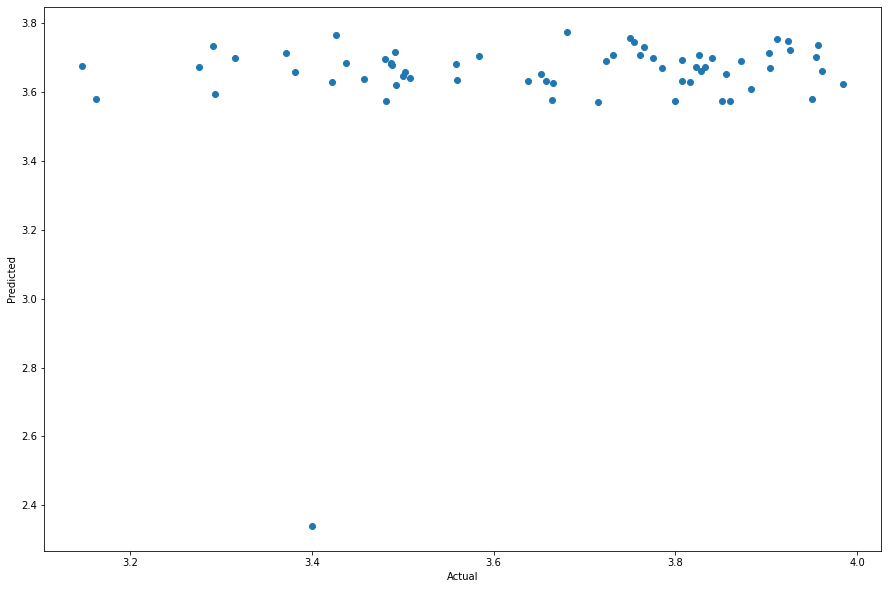

In [172]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [173]:
grades_numeric = pd.read_csv('grades_numeric.csv')
sleep_grade = pd.merge(grades_numeric, average_sleeps, on=['egoid'])
sleep_grade.to_csv('sleep_grade.csv', index=False)

# sleep_grade.drop('')
corr_matrix = sleep_grade.corr().abs()
corr_matrix.to_csv('corr_matrix.csv', index=True)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# df.drop(to_drop, axis=1, inplace=True)
print(to_drop)

['efficiency_avg', 'sleep_score']


In [174]:
# sns.pairplot(sleep_grade, hue='egoid')